In [1]:
%%capture
!pip install datasets transformers

In [2]:
from datasets import load_dataset

ds = load_dataset("RiniPL/Dementia_Dataset")

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 65
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 65
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 65
    })
})

In [54]:
im = ds['train'][25]
print(im)
image = im['image']
print(im)

image


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7BF9401FA830>, 'label': 2}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7BF9401FA830>, 'label': 2}


TypeError: ignored

In [4]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], id=None)

In [55]:
labels.int2str(im['label'])

'Non_Demented'

##Se prepara las imagenes para el modelo

Usare el modelo microsoft/resnet-50

In [6]:
from transformers import ViTFeatureExtractor

repo_id = "microsoft/resnet-50"
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
print(feature_extractor)

ViTFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Las imagenes vienen a escala de grises (2 dimensiones) por lo que se tienen que convertir a lo que espera la funcion

In [8]:
from PIL import Image
import torch

def transform(example_batch):
    # Crear una lista para almacenar las imágenes convertidas
    imagenes_rgb = []

    # Iterar a través de las imágenes en escala de grises
    for imagen_gris in example_batch["image"]:
        # Convertir la imagen en escala de grises a RGB
        imagen_rgb = Image.merge("RGB", (imagen_gris, imagen_gris, imagen_gris))

        # Agregar la imagen convertida a la lista
        imagenes_rgb.append(imagen_rgb)

    # Utilizar el extractor de características en las imágenes RGB
    inputs = feature_extractor(imagenes_rgb, return_tensors="pt")

    # Agregar las etiquetas
    inputs["labels"] = example_batch['label']

    return inputs

In [9]:
prepared_ds = ds.with_transform(transform)

In [10]:
prepared_ds['train'][10]

{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [11]:
prepared_ds["train"][0:2]["labels"]

[0, 0]

Se define el data collator

In [12]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x['labels'] for x in batch])
  }

##Entrenamiento y evaluaución

Definiendo la metrica

In [13]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(prediction):
  return metric.compute(predictions = np.argmax(prediction.predictions,axis=1), references=prediction.label_ids)

<ipython-input-13-578c103435d3>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Se configura Trainer

In [14]:
from transformers import ViTForImageClassification

label = ds["train"].features["label"].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels = len(label),
    id2label={str(i): c for i, c in enumerate(label)},
    label2id={c: str(i) for i, c in enumerate(label)},
    ignore_mismatched_sizes=True
)

You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized: ['encoder.layer.3.attention.attention.value.weight', 'encoder.layer.7.attention.attention.key.bias', 'encoder.layer.2.attention.attention.value.bias', 'encoder.layer.7.intermediate.dense.weight', 'embeddings.patch_embeddings.projection.bias', 'encoder.layer.7.attention.output.dense.weight', 'encoder.layer.9.attention.attention.query.weight', 'encoder.layer.11.layernorm_before.bias', 'encoder.layer.10.attention.output.dense.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.7.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.7.attention.attention.value.bias', 'encoder.layer.2.attention.attention.key.weight', 'encoder.layer.11.attention.attention

In [15]:
%%capture
!pip install Transformers[torch]
!pip install accelerate -U

In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model-Dementia-classification-Alejandro-Arroyo",
    evaluation_strategy="steps",
    num_train_epochs=20,
    learning_rate=5e-5,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True
)

In [30]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Traceback (most recent call last):
  File "/usr/local/bin/huggingface

In [35]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor
)

##Entrenamiento

In [36]:
train_results=trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

Step,Training Loss,Validation Loss


training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

***** train metrics *****
  epoch                    =       20.0
  total_flos               = 93822732GF
  train_loss               =     0.5491
  train_runtime            = 0:00:52.84
  train_samples_per_second =     24.601
  train_steps_per_second   =      3.406


##Evaluation


In [37]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9231
  eval_loss               =     0.1858
  eval_runtime            = 0:00:01.14
  eval_samples_per_second =     56.665
  eval_steps_per_second   =      7.846


##Lo comparto en el Hub

In [38]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": "RiniPL/Dementia_Dataset",
    "tags": ["image-classification"]
}

trainer.push_to_hub(commit_message="Clasificador de imagenes para saber que grado de demencia existe en la persona", **kwargs)

'https://huggingface.co/Alex14005/model-Dementia-classification-Alejandro-Arroyo/tree/main/'

Mild-Demented

In [64]:
im2 = ds['train'][10]
image2=im2['image']
labels.int2str(im2['label'])
image2.save('Mild-demented.jpg')

In [65]:
labels.int2str(im2['label'])

'Mild_Demented'

No-demented

In [60]:
# Elige el índice de la imagen que deseas descargar
im = ds['train'][25]
print(im)
image = im['image']

# Guarda la imagen en un archivo
image.save('No-demented.jpg')

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7BF92820A9B0>, 'label': 2}


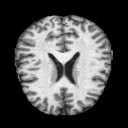

In [63]:
image

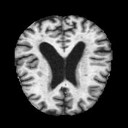

In [66]:
image2